Load Data

In [1]:
import pandas as pd
import pyreadstat

In [2]:
dhs_df, meta = pyreadstat.read_sav("ETMR70FL.SAV")

In [3]:
dhs_df.shape

(12688, 590)

In [4]:
insurance_df = dhs_df[[ 'MV024', 'MV135',  'MV190', 'MV714', 'MV717','MV102', 'MV201', 'MV035', 'MV106','MV481']] #'MV013','MV102', 'MV201', 'MV035', 'MV106',
column_mapping = dict(zip(meta.column_names, meta.column_labels))
insurance_filled = insurance_df.rename(columns=column_mapping)

In [5]:
insurance_filled

,Region,Usual resident or visitor,Wealth index combined,Currently working,Occupation (grouped),Type of place of residence,Total children ever born,Number of wives/partners,Educational level,Covered by health insurance
0,4.0,1.0,2.0,1.0,5.0,2.0,8.0,1.0,0.0,0.0
1,4.0,1.0,2.0,1.0,5.0,2.0,8.0,1.0,0.0,0.0
2,4.0,1.0,2.0,0.0,0.0,2.0,6.0,1.0,0.0,0.0
3,4.0,1.0,3.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0
4,4.0,1.0,2.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12683,10.0,1.0,5.0,1.0,8.0,1.0,0.0,1.0,3.0,0.0
12684,10.0,1.0,5.0,1.0,96.0,1.0,0.0,0.0,2.0,0.0
12685,10.0,1.0,5.0,1.0,8.0,1.0,3.0,1.0,1.0,0.0
12686,10.0,1.0,5.0,1.0,8.0,1.0,2.0,1.0,2.0,0.0


In [6]:
insurance_filled.isnull().sum()

Region                         0
Usual resident or visitor      0
Wealth index combined          0
Currently working              0
Occupation (grouped)           0
Type of place of residence     0
Total children ever born       0
Number of wives/partners       0
Educational level              0
Covered by health insurance    0
dtype: int64

In [7]:
insurance_filled['Covered by health insurance'].value_counts()

Covered by health insurance
0.0    11959
1.0      729
Name: count, dtype: int64

In [8]:
import matplotlib.pyplot as plt

Check For Multicollinearity

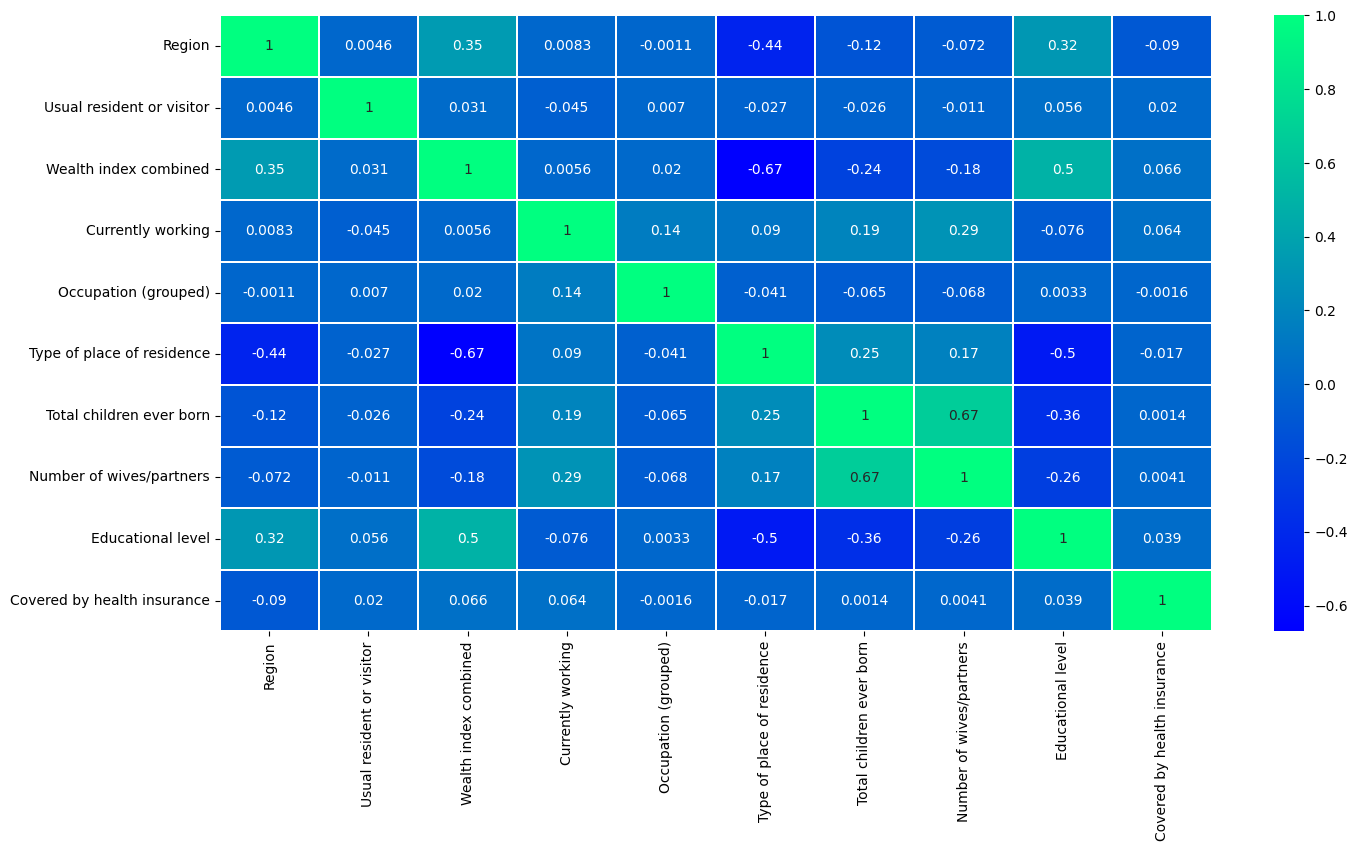

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize= (16,8))
sns.heatmap(insurance_filled.corr(), linewidths= 0.02, annot=True, cmap='winter')
plt.show()

Data Preparation

In [10]:
# Load your dataset
target = insurance_filled['Covered by health insurance']
feature = insurance_filled.iloc[:,:-1]

In [11]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=42, stratify=target)

In [12]:
y_train.value_counts()

Covered by health insurance
0.0    8371
1.0     510
Name: count, dtype: int64

Handling Imbalance

In [13]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Resampling strategy
oversample = ADASYN(sampling_strategy=1, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=1, random_state=42)

# Combine oversampling and undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('o', oversample), ('u', undersample)])

# Apply the resampling strategy to the training data
X_resampled, y_resampled = resample_pipeline.fit_resample(X_train, y_train)

# The new class distribution
print('Resampled dataset shape:', Counter(y_resampled))

Resampled dataset shape: Counter({0.0: 8282, 1.0: 8282})


Model Training

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Train the model on the resampled data
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = model.predict(X_test)


Feature Importance

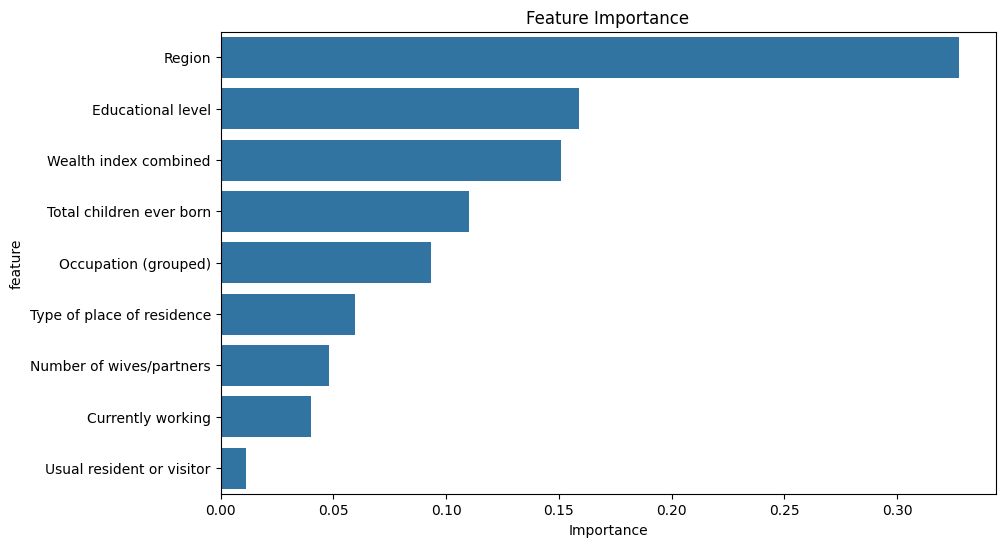

In [15]:
importances = model.feature_importances_
feature_names = X_resampled.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

Exploring Top Three Features

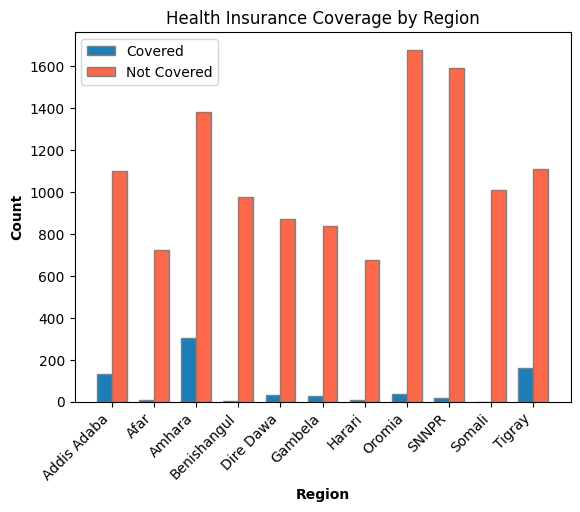

In [16]:
import numpy as np 
insurance_filled['Region'] = insurance_filled['Region'].map(meta.value_labels['labels4'])
agg_data = insurance_filled.groupby(['Region', 'Covered by health insurance'], observed= True).size().unstack(fill_value=0)

bar_width = 0.35
r1 = np.arange(len(agg_data))
r2 = [x + bar_width for x in r1]

plt.bar(r1, agg_data[1], color=plt.cm.GnBu(0.8), width=bar_width, edgecolor='grey', label='Covered')
plt.bar(r2, agg_data[0], color=plt.cm.Reds(0.5), width=bar_width, edgecolor='grey', label='Not Covered')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Health Insurance Coverage by Region')
plt.xticks([r + bar_width/2 for r in range(len(agg_data))], agg_data.index, rotation=45, ha='right')
plt.legend()
plt.show()

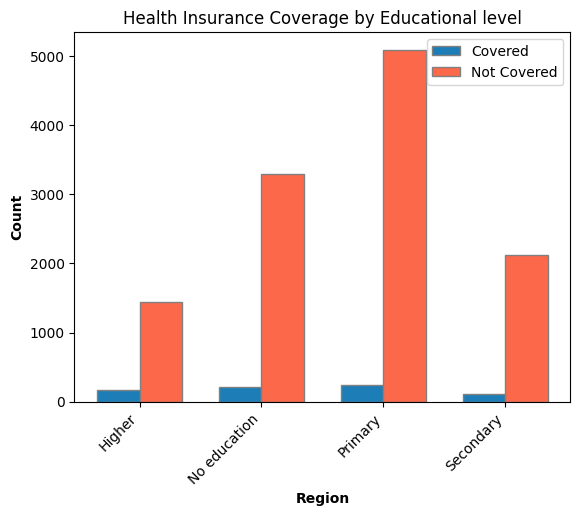

In [17]:
import numpy as np 
insurance_filled['Educational level'] = insurance_filled['Educational level'].map(meta.value_labels['labels35'])
agg_data = insurance_filled.groupby(['Educational level', 'Covered by health insurance'], observed= True).size().unstack(fill_value=0)

bar_width = 0.35
r1 = np.arange(len(agg_data))
r2 = [x + bar_width for x in r1]

plt.bar(r1, agg_data[1], color=plt.cm.GnBu(0.8), width=bar_width, edgecolor='grey', label='Covered')
plt.bar(r2, agg_data[0], color=plt.cm.Reds(0.5), width=bar_width, edgecolor='grey', label='Not Covered')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Health Insurance Coverage by Educational level')
plt.xticks([r + bar_width/2 for r in range(len(agg_data))], agg_data.index, rotation=45, ha='right')
plt.legend()
plt.show()

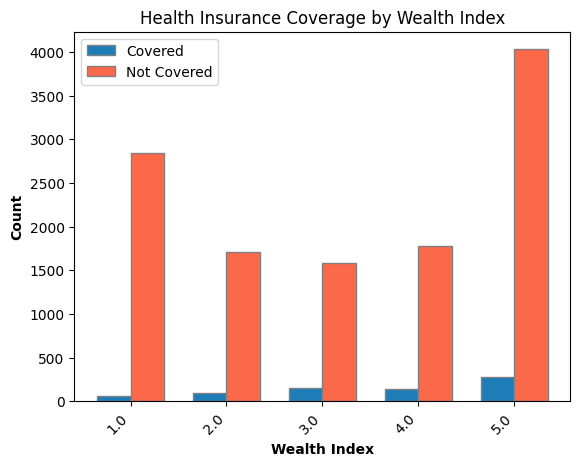

In [18]:
import numpy as np 
agg_data = insurance_filled.groupby(['Wealth index combined', 'Covered by health insurance'], observed= True).size().unstack(fill_value=0)

bar_width = 0.35
r1 = np.arange(len(agg_data))
r2 = [x + bar_width for x in r1]

plt.bar(r1, agg_data[1], color=plt.cm.GnBu(0.8), width=bar_width, edgecolor='grey', label='Covered')
plt.bar(r2, agg_data[0], color=plt.cm.Reds(0.5), width=bar_width, edgecolor='grey', label='Not Covered')
plt.xlabel('Wealth Index', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Health Insurance Coverage by Wealth Index')
plt.xticks([r + bar_width/2 for r in range(len(agg_data))], agg_data.index, rotation=45, ha='right')
plt.legend()
plt.show()

Evaluating the model

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      3588
         1.0       0.24      0.34      0.28       219

    accuracy                           0.90      3807
   macro avg       0.60      0.64      0.61      3807
weighted avg       0.92      0.90      0.91      3807



Confusion Matrix

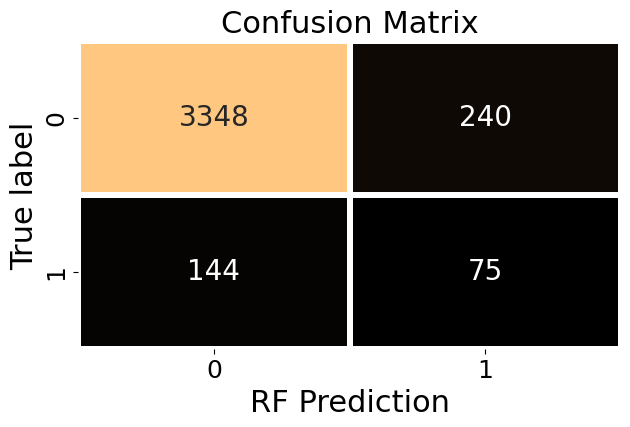

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(7, 4))

sns.heatmap(cm, annot=True, fmt='d', linewidth=4, cbar=False, annot_kws={'size': 20}, cmap='copper')

plt.xlabel('RF Prediction', fontsize=22)
plt.ylabel('True label', fontsize=22)
plt.title('Confusion Matrix', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

AUC-ROC Curve

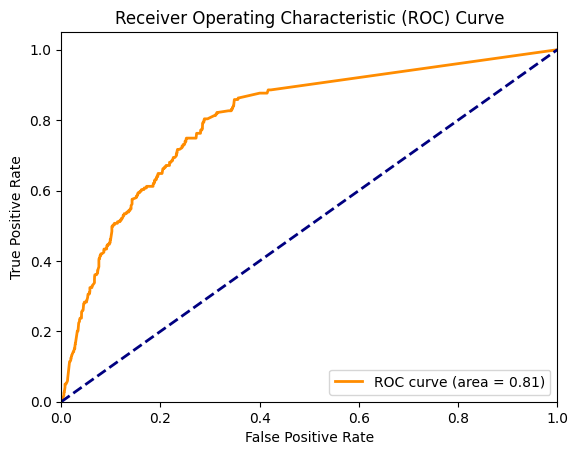

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()